In [81]:
import physionet_challenge_utility_script as pc

import ecg_plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.preprocessing.sequence import pad_sequences

print(1)

%load_ext autoreload
%autoreload
%reload_ext autoreload


1
The autoreload extension is already loaded. To reload it, use:ERROR! Session/line number was not unique in database. History logging moved to new session 190

  %reload_ext autoreload


In [82]:
DATADIR = "./SM22_MLData"

In [83]:
firstModelData = {}
firstModelData["gender"], firstModelData["age"], firstModelData["labels"], firstModelData["ecg_filenames"] = pc.import_key_data(DATADIR)
firstModelData["ecg_filenames"] = np.asarray(firstModelData["ecg_filenames"])

In [84]:
cache = firstModelData["labels"]

In [85]:
"""
Remaps labels into class values (Integer Encoding)
val: totalRhythm
1 - SR
2 - NSR
3 - Both
"""

print(len(firstModelData["labels"]))
for i in range(len(firstModelData["labels"])):
    splitLabels = firstModelData["labels"][i].split(",")
    isSR, isNSR, totalRhythm = 0, 0, 0
    if len(splitLabels) > 1:
        isNSR = 2 #NSR
    if not("426783006" in splitLabels):
        isNSR = 2 #NSR
    if "426783006" in splitLabels:
        isSR = 1 #SR
    totalRhythm = isSR + isNSR
    firstModelData["labels"][i] = str(totalRhythm)


43101


In [86]:
firstModelData["labels"][0] = "2,undefined"

In [87]:
firstModelData["age"], firstModelData["gender"] = pc.import_gender_and_age(firstModelData["age"], firstModelData["gender"])

gender data shape: 43101
age data shape: 43101


In [88]:
SNOMED_scored=pd.read_csv(f"{DATADIR}/SNOMEDMappings/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv(f"{DATADIR}/SNOMEDMappings/FIRSTMODELMapping.csv", sep=",")

In [89]:
df_labels = pd.DataFrame(firstModelData["labels"])

In [90]:
y , snomed_classes = pc.onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['1' '2' '3' 'undefined']
classes: 3


In [91]:
y

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [92]:
y_all_comb = pc.get_labels_for_all_combinations(y)

In [93]:
folds = pc.split_data(firstModelData["labels"], y_all_comb)

Training split: 38790
Validation split: 4311


In [94]:
order_array = folds[0][0]

In [95]:
def shuffle_batch_generator_demo(batch_size, gen_x,gen_y, gen_z): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    batch_demo_data = np.zeros((batch_size,2))
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            batch_demo_data[i] = next(gen_z)

        X_combined = [batch_features, batch_demo_data]
        yield X_combined, batch_labels
        
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = pc.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

def generate_z_shuffle(age_train, gender_train):
    while True:
        for i in order_array:
            gen_age = age_train[i]
            gen_gender = gender_train[i]
            z_train = [gen_age , gen_gender]
            yield z_train

In [96]:
new_weights=pc.calculating_class_weights(y)

In [97]:
keys = np.arange(0,3,1)
weight_dictionary = dict(zip(keys, new_weights.T[1]))
weight_dictionary

{0: 2.34703768242213, 1: 0.9683441923163334, 2: 1.847608024691358}

In [98]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=2, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=4)

In [19]:
from scipy import optimize
def thr_chall_metrics(thr, label, output_prob):
    return -pc.compute_challenge_metric_for_opt(label, np.array(output_prob>thr))

In [20]:
def myFCN(classes=27):
    inputlayer = keras.layers.Input(shape=(5000,12)) 

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8,input_shape=(5000,12), padding='same')(inputlayer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv1)

    outputlayer = keras.layers.Dense(classes, activation='sigmoid')(gap_layer)

    model = keras.Model(inputs=inputlayer, outputs=outputlayer)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

    return model

In [99]:
model = pc.residual_network_1d(classes=3)

In [135]:
model.load_weights("test.h5")

In [29]:
init_thresholds = np.arange(0,1,0.05)

In [136]:
dat = pc.generate_validation_data(firstModelData["ecg_filenames"],y,folds[0][1])
x = dat[0]
y_true = dat[1]
y_pred = model.predict(x=x)

In [137]:
y_pred

array([[5.2749328e-05, 9.8842186e-01, 1.1525367e-02],
       [1.3004783e-11, 1.0000000e+00, 2.9322503e-11],
       [1.5266984e-11, 1.0000000e+00, 1.5895140e-15],
       ...,
       [7.4282807e-01, 2.5521106e-01, 1.9608776e-03],
       [9.8582241e-05, 9.9990141e-01, 4.2568556e-13],
       [1.0000000e+00, 7.3842417e-12, 3.4216630e-20]], dtype=float32)

In [150]:
y_pred_round = np.round_(y_pred)
np.where(y_pred_round == y_true, [y_pred, y_true])

ValueError: either both or neither of x and y should be given

In [31]:
all_scores = pc.iterate_threshold(y_pred, firstModelData["ecg_filenames"], y ,folds[0][1])

ValueError: operands could not be broadcast together with shapes (27,27) (3,3) 

In [56]:
pc.plot_normalized_conf_matrix(y_pred, firstModelData["ecg_filenames"], y, folds[0][1], snomed_classes, ["1","2","3"])

TypeError: plot_normalized_conf_matrix() missing 1 required positional argument: 'snomedabbr'

In [155]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

In [156]:
from sklearn.metrics import ConfusionMatrixDisplay
conf_mat

array([[ 754,   71,   94],
       [ 149, 1951,  126],
       [ 219,   46,  901]])

In [157]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["1","2","3"])

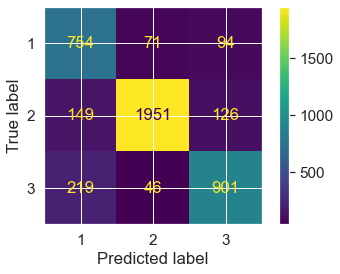

In [158]:
disp.plot()